In [ ]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf

import cv2

from progress.bar import Bar
from ipywidgets import IntProgress
from IPython.display import display

from model import VGG16

In [ ]:
original_file = '/data/put_data/timliu/kidney/pro_img/GE/meta.csv'

In [ ]:
mydirs = ['/data/put_data/timliu/kidney/pro_img/GE/clahe'+str(i)+'_right' for i in range(5,26,5)]+['/data/put_data/timliu/kidney/pro_img/GE/clahe'+str(i)+'_left' for i in range(5,26,5)]

In [ ]:
ori = pd.read_csv(original_file, index_col = False)
df = ori.copy()
if len(mydirs)>0:
    for dirn in mydirs:
        tmp = pd.read_csv(dirn+'/df_with_labels.csv', index_col = False)
        print(tmp.shape)
        df = df.append(tmp)

df = df[(df.length != 'Suspension')].reset_index()

ori = ori[(ori.length != 'Suspension')].reset_index()

df.length = df.length.astype('float')
print(df.shape)
print(ori.shape)
df.head()

In [ ]:
ratio = 0.75
random.seed(45)
train_id = []
test_id = []
for i in range(0, 34):
    df_sub = df[df['egfr_mdrd'].between(5*i, 5*(i+1), inclusive = (True, False))]
    d_list = Series.tolist(df_sub['uid_date'])
    d_list = list(set(d_list))
    random.shuffle(d_list)
    train_id += d_list[:int(ratio*len(d_list))]
    test_id += d_list[int(ratio*len(d_list)):]
print('all:', len(set(df.uid_date)), 'train:', len(train_id), 'test:', len(test_id))

In [ ]:
class Dataset(object):
    def __init__(self, uid, df, crop_size, resize_size):
        index = np.where(df['uid_date'].isin(uid))[0]
        images = []
        labels = []
        weights = []
        for i in index:
            img = self._load_image(df['path'][i], crop_size, resize_size)
            label = df['egfr_mdrd'][i]
            if label < 30:
                weight = 3
            elif label < 60:
                weight = 1
            elif label < 90:
                weight = 3
            else:
                weight = 9
            images.append(img)
            labels.append(label)
            weights.append(weight)
        self.images = np.array(images)
        self.labels = np.array(labels)
        self.weights = np.array(weights)
    
    def _load_image(self, path, crop_size, resize_size):
        # load image
        img = cv2.imread(path,1)
        # we crop image from center
        yy = int((img.shape[0] - crop_size) / 2)
        xx = int((img.shape[1] - crop_size) / 2)
        crop_img = img[yy: yy + crop_size, xx: xx + crop_size]
        # resize to 224, 224
        resized_img = cv2.resize(crop_img,(resize_size,resize_size),interpolation=cv2.INTER_AREA)
        return resized_img
    
    def shuffle(self):
        idx = np.random.permutation(self.images.shape[0])
        self.images = self.images[idx,:,:,:]
        self.labels = self.labels[idx]
        self.weights = self.weights[idx]

In [13]:
save_dir = "/Users/chunmingchang/renal-eGFR/test"
init_from = "/Users/chunmingchang/renal-eGFR/vgg16.npy"

def vgg16_train(train, test, init_from, save_dir, batch_size=64, epoch=300, early_stop_patience=25):
    vgg16 = VGG16(vgg16_npy_path=init_from)
    vgg16.build()

    saver = tf.train.Saver(tf.global_variables(), max_to_keep=2)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    checkpoint_path = os.path.join(save_dir, 'model.ckpt')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # hyper parameters
        learning_rate =  5e-4 #adam
        min_delta = 0.0001

        # recorder
        epoch_counter = 0
        loss_history = []
        val_loss_history = []

        # optimizer
        opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = opt.minimize(vgg16.loss)

        # progress bar
        ptrain = IntProgress()
        pval = IntProgress()
        display(ptrain)
        display(pval)
        ptrain.max = int(train.images.shape[0]/batch_size)
        pval.max = int(test.images.shape[0]/batch_size)

        # reset due to adding a new task
        patience_counter = 0
        current_best_val_loss = 100000 # a large number
        

        # train start
        while(patience_counter < early_stop_patience):
            stime = time.time()
            bar_train = Bar('Training', max=int(train.images.shape[0]/batch_size), suffix='%(index)d/%(max)d - %(percent).1f%% - %(eta)ds')
            bar_val =  Bar('Validation', max=int(test.images.shape[0]/batch_size), suffix='%(index)d/%(max)d - %(percent).1f%% - %(eta)ds')
            
            # training an epoch
            train_loss = 0
            for i in range(int(train.images.shape[0]/batch_size)):
                st = i*batch_size
                ed = (i+1)*batch_size
                
                _, loss = sess.run([train_op, vgg16.loss ],
                                   feed_dict={vgg16.x: train.images[st:ed,:],
                                              vgg16.y: train.labels[st:ed,:],
                                              vgg16.w: train.weights[st:ed,:]
                                             })
                train_loss += loss
                ptrain.value +=1
                ptrain.description = "Training %s/%s" % (i, ptrain.max)
                bar_train.next()
            
            train_loss /= ptrain.max

            # validation
            val_loss = sess.run([vgg16.loss],
                                feed_dict={vgg16.x: test.images,
                                            vgg16.y: test.labels,
                                            vgg16.w: np.repeat(1.0,test.images.shape[0])})


            if (current_best_val_loss - val_loss) > min_delta:
                current_best_val_loss = val_loss
                patience_counter = 0
                saver.save(sess, checkpoint_path, global_step=epoch_counter)
                print("reset early stopping and save model into %s at epoch %s" % (checkpoint_path,epoch_counter))
            else:
                patience_counter += 1

            # shuffle Xtrain and Ytrain in the next epoch
            train.shuffle()

            # epoch end
            epoch_counter += 1
            
            loss_history.append(train_loss)
            val_loss_history.append(val_loss)

            ptrain.value = 0
            pval.value = 0
            bar_train.finish()
            bar_val.finish()

            print("Epoch %s (%s), %s sec >> train-loss: %.4f, val-loss: %.4f" % (epoch_counter, patience_counter, round(time.time()-stime,2), train_loss, val_loss))
        res = pd.DataFrame({"epoch":range(0,len(loss_history)), "loss":loss_history, "val_loss":val_loss_history})
        res.to_csv(os.path.join(save_dir,"history.csv"), index=False)
        print("end training")

def plot_making(save_dir, true, pred, types):
    cor = pearsonr(true, pred)[0]
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred) 
    plt.figure(0)
    plt.scatter(true, pred, alpha = .15, s = 20)
    plt.xlabel('True_Y')
    plt.ylabel('Pred_Y')
    plt.title(" data \n" + "MAE = %4f; Cor = %4f; R2 = %4f; #samples = %d" % (mae, cor, r2, len(true)))
    plt.savefig(save_dir + types + "_plot_scatter.png" , dpi = 200)
    plt.show()
    plt.close()
    
    hist = pd.read_csv(os.path.join(save_dir, "history.csv"))
    
    plt.figure(0)
    hist.plot(x='epoch', markevery=5)
    plt.xlabel('Epoch')
    plt.savefig(save_dir+"history.png",dpi=200)
    plt.show()
    plt.close()
    
def save_plot(save_dir, test):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(save_dir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            sess.run(tf.global_variables())

            val_loss, pred = sess.run([vgg16.loss, vgg16.output],
                                      feed_dict={vgg16.x: test.images,
                                                 vgg16.y: test.labels,
                                                 vgg16.w: np.repeat(1.0, test.images.shape[0])})

            plot_making(save_dir, test.labels, pred, types="test")

In [17]:
d=pd.read_csv("history.csv")

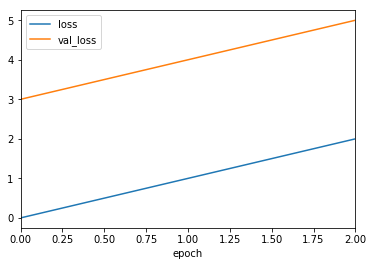

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt


In [16]:
loss_history = [0,1,2]
val_loss_history = [3,4,5]
res = pd.DataFrame({"epoch":range(0,len(loss_history)), "loss":loss_history, "val_loss":val_loss_history})
res.to_csv(os.path.join(os.getcwd(),"history.csv"), index=False)

In [ ]:
crop_size = 350
resize_size = 224
train = Dataset(train_id, df, crop_size, resize_size)
test  = Dataset(test_id, ori, crop_size, resize_size)

In [ ]:
vgg16_train(train, test, save_dir=save_dir, init_from=init_from, batch_size=64, epoch=300, early_stop=25)
save_plot(save_dir, test)